In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
data = pd.read_excel("/content/drive/MyDrive/cluster_data1.xlsx")

In [3]:
data # FA 이후 수직회전한 데이터

,motivation,physical,emotional
0,-0.669134,1.779119,1.397369
1,-0.011060,0.280498,0.407592
2,2.278064,-0.972721,-0.995542
3,-0.477011,0.251564,-0.310520
4,0.313843,2.903056,-0.837597
...,...,...,...
39770,1.961546,-0.550742,-1.339853
39771,0.992465,1.707210,-0.058432
39772,-0.866372,-0.828334,-0.988357
39773,-1.007812,0.171188,1.299108


총 39775개의 데이터에서 랜덤한한 3000개 데이터 추출

In [4]:
import random
random.seed(123)
drop_random = list(range(39775))
for i in range(3000):
  drop_choice = random.choice(drop_random)
  drop_random.remove(drop_choice)
for i in drop_random:
  data = data.drop(i,axis=0)

In [5]:
data

,motivation,physical,emotional
7,-1.066920,-0.482416,-0.965835
22,1.107883,1.142016,-0.167817
23,-0.531137,-0.733275,1.141257
53,-1.213510,1.319785,0.464762
64,-0.398582,-0.909878,0.667486
...,...,...,...
39734,1.275523,-0.158417,1.706220
39739,1.385161,0.531276,0.883788
39757,1.346693,-1.557512,0.200226
39763,-0.043217,-0.056196,-0.328070


# Clustering

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

In [7]:
from IPython.display import display
display(data.head())
print('\n', data.shape)

,motivation,physical,emotional
7,-1.066920,-0.482416,-0.965835
22,1.107883,1.142016,-0.167817
23,-0.531137,-0.733275,1.141257
53,-1.213510,1.319785,0.464762
64,-0.398582,-0.909878,0.667486



 (3000, 3)


In [8]:
# 이상치 제거 함수 (1Q - 1.5*IQR, 3Q + 1.5*IQR 을 넘어가는 값을 가진 행을 제거)
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [9]:
for col in data.columns:
    outlier_idx = get_outlier(df=data, column=col, weight=1.5)
    data.drop(outlier_idx, axis=0, inplace=True)

총 7개의 데이터가 제거된 것을 확인할 수 있다.

In [10]:
display(data.head())
print('\n', data.shape)

,motivation,physical,emotional
7,-1.066920,-0.482416,-0.965835
22,1.107883,1.142016,-0.167817
23,-0.531137,-0.733275,1.141257
53,-1.213510,1.319785,0.464762
64,-0.398582,-0.909878,0.667486



 (2993, 3)


In [11]:
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler().fit_transform(data)
scaled = pd.DataFrame(scaled, columns = data.columns)
scaled.describe() # 기초통계량

,motivation,physical,emotional
count,2.993000e+03,2.993000e+03,2.993000e+03
mean,1.899212e-17,7.122045e-18,-4.748030e-18
std,1.000167e+00,1.000167e+00,1.000167e+00
min,-2.668483e+00,-2.693410e+00,-2.670602e+00
25%,-8.467702e-01,-7.710692e-01,-7.369312e-01
50%,-9.344370e-02,-1.784459e-01,-2.050546e-03
75%,8.394354e-01,6.883769e-01,7.469490e-01
max,2.911159e+00,2.830604e+00,2.699617e+00


## 1. Complete linkeage(non-euclidean-cosine 방법 사용)

## Step 1. 거리 계산에 따른 클러스터링


In [12]:
data_prime = scaled.copy()

In [13]:
# used complete linkeage
# used non-euclidean distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
clusters = linkage(y=data_prime, method='complete', metric='cosine')

## Step 2. 군집 수 결정

덴도그램

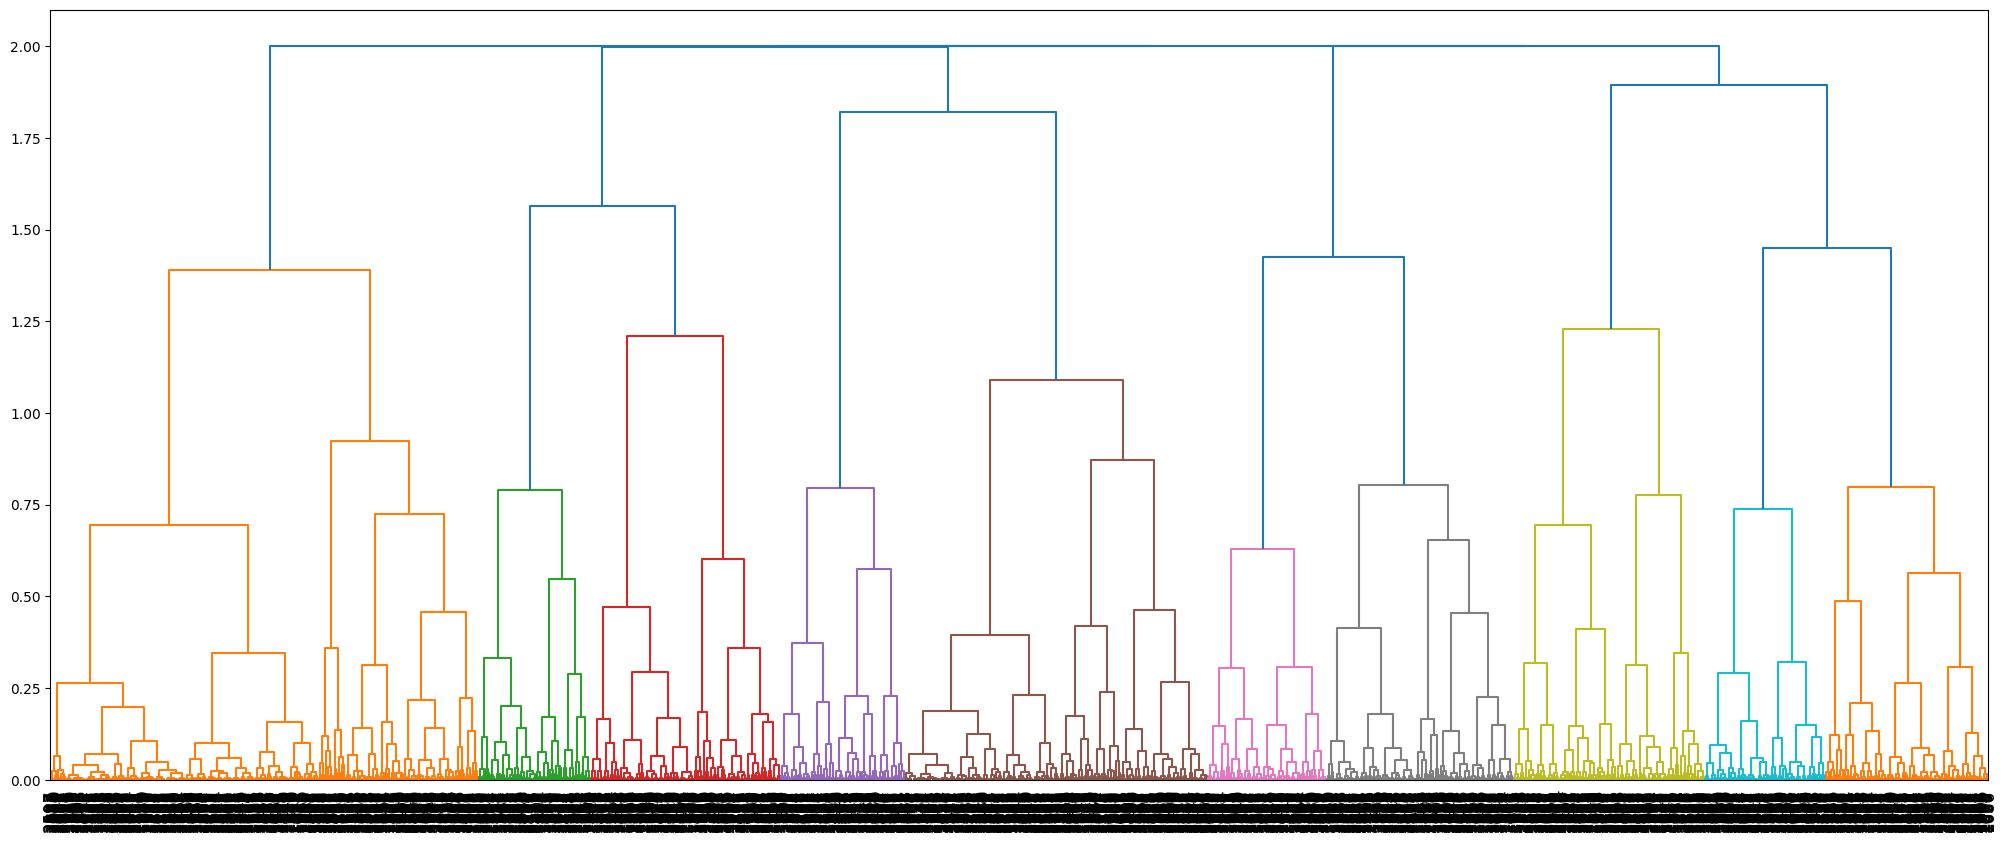

In [14]:
import matplotlib.pyplot as plt
plt.figure( figsize = (25, 10) )
dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
plt.show()

여러 T 값을 이용해 실루엣 스코어를 비교했고, 그 중 가장 적합했던 T 값을 현재 코드에 적용시켰다.

In [33]:
cut_tree = fcluster(clusters, t=1.8, criterion='distance')
cut_tree

array([1, 3, 5, ..., 6, 1, 1], dtype=int32)

In [34]:
pd.Series(cut_tree).value_counts()

1    661
5    473
4    468
2    467
7    437
6    295
3    192
dtype: int64

## Step 3. Evaluation


군집별/평균 실루엣 계수 계산

In [35]:
from sklearn.metrics import silhouette_samples, silhouette_score
score_samples = silhouette_samples(data_prime, cut_tree)
print('Silhouette Score:', score_samples[:5], '\nSilhouette Score shape:', score_samples.shape, '\n')

average_score = silhouette_score(data_prime, cut_tree)
# np.mean(score_samples) == average_score: True
print('Silhouette Average Score:{0:.3f}'.format(average_score))

Silhouette Score: [0.46486984 0.22019338 0.42546296 0.30254772 0.11652959] 
Silhouette Score shape: (2993,) 

Silhouette Average Score:0.326


In [36]:
data_prime['hc_cluster'] = cut_tree
data_prime['silhouette_coeff'] = score_samples
data_prime

,motivation,physical,emotional,hc_cluster,silhouette_coeff
0,-1.130394,-0.551188,-1.060694,1,0.464870
1,1.175179,1.238131,-0.175303,3,0.220193
2,-0.562395,-0.827510,1.277099,5,0.425463
3,-1.285799,1.433943,0.526536,2,0.302548
4,-0.421869,-1.022040,0.751456,6,0.116530
...,...,...,...,...,...
2988,1.352899,-0.194302,1.903919,7,0.341443
2989,1.469130,0.565398,0.991440,7,0.429305
2990,1.428349,-1.735410,0.233037,6,0.170976
2991,-0.045136,-0.081705,-0.353101,1,0.228275


In [37]:
# 군집별 평균 silhouette_score 값
print(data_prime.groupby('hc_cluster')['silhouette_coeff'].mean())
print('표준편차:', data_prime.groupby('hc_cluster')['silhouette_coeff'].mean().std())

hc_cluster
1    0.426460
2    0.299310
3    0.291414
4    0.317228
5    0.383990
6    0.215569
7    0.238089
Name: silhouette_coeff, dtype: float64
표준편차: 0.07487465915701859


In [38]:
cluster_g = data_prime.groupby('hc_cluster')

Motivation, Physical, Emotional 3개의 성분을 이용해 2차원 플롯 3개, 3차원 플롯 1개를 그렸다.

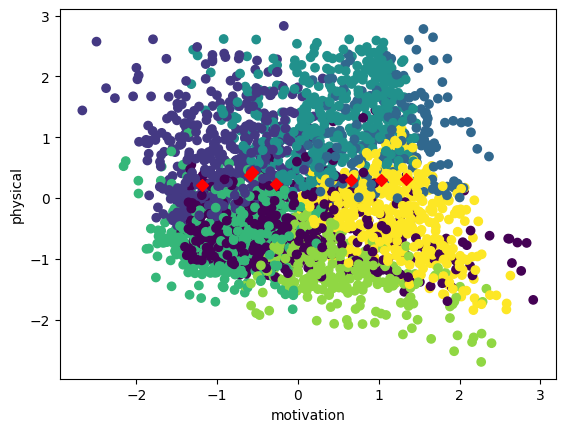

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(x=data_prime['motivation'], y=data_prime['physical'], c=data_prime['hc_cluster']) # 각 cluster 좌푯값 시각화

hc_centers = np.array(cluster_g.mean()) # 각 cluster별 centroid
plt.scatter(x=hc_centers[:,1], y=hc_centers[:,3], marker='D', c='r') # 각 cluster별 centroid 시각화
# marker='D', c='r' : 마커 모양은 Diamond, 색깔은 red
plt.xlabel('motivation')
plt.ylabel('physical')
plt.show()
# scatterplot = 군집들의 구분, centroid 확인 등등 

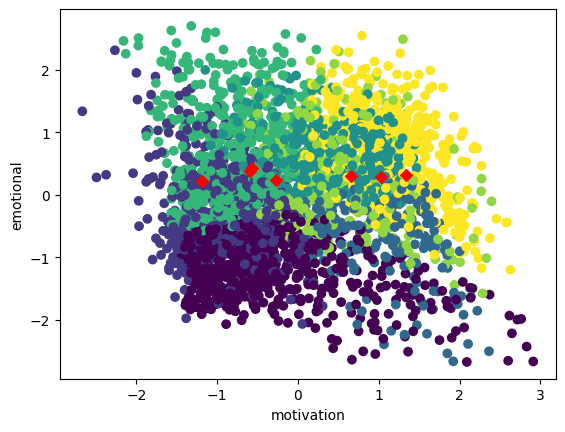

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(x=data_prime['motivation'], y=data_prime['emotional'], c=data_prime['hc_cluster']) # 각 cluster 좌푯값 시각화

hc_centers = np.array(cluster_g.mean()) # 각 cluster별 centroid
plt.scatter(x=hc_centers[:,1], y=hc_centers[:,3], marker='D', c='r') # 각 cluster별 centroid 시각화
# marker='D', c='r' : 마커 모양은 Diamond, 색깔은 red
plt.xlabel('motivation')
plt.ylabel('emotional')
plt.show()
# scatterplot = 군집들의 구분, centroid 확인 등등 

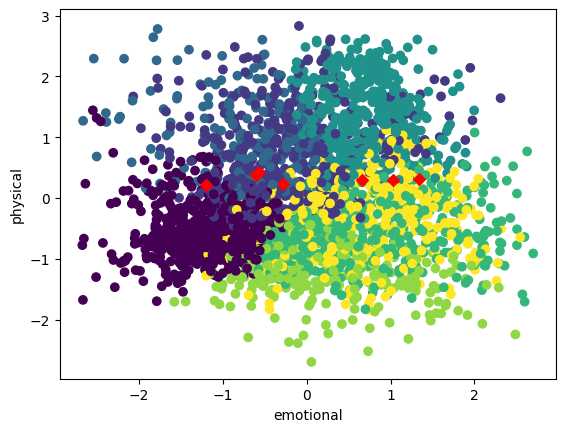

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(x=data_prime['emotional'], y=data_prime['physical'], c=data_prime['hc_cluster']) # 각 cluster 좌푯값 시각화

hc_centers = np.array(cluster_g.mean()) # 각 cluster별 centroid
plt.scatter(x=hc_centers[:,1], y=hc_centers[:,3], marker='D', c='r') # 각 cluster별 centroid 시각화
# marker='D', c='r' : 마커 모양은 Diamond, 색깔은 red
plt.xlabel('emotional')
plt.ylabel('physical')
plt.show()
# scatterplot = 군집들의 구분, centroid 확인 등등 

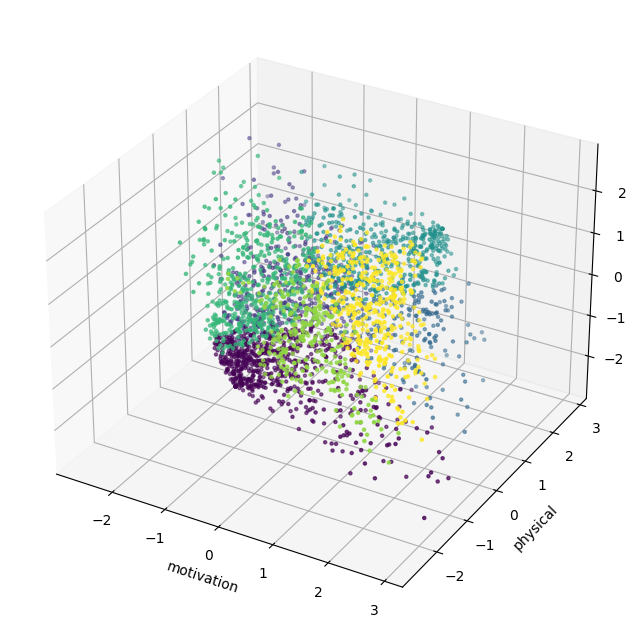

In [42]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_prime['motivation'], data_prime['physical'], data_prime['emotional'], s=5, c = data_prime['hc_cluster'])
ax.set_xlabel('motivation', rotation=150)
ax.set_ylabel('physical')
ax.set_zlabel(r'emotional', rotation=60)
plt.show()

## Step 4. EDA/Interpretation

In [43]:
# 군집별 통계(평균)
cluster_g.mean()

,motivation,physical,emotional,silhouette_coeff
hc_cluster,,,,
1,-0.367462,-0.567966,-1.192029,0.426460
2,-0.937546,0.657896,-0.222973,0.299310
3,1.080259,1.030105,-0.719854,0.291414
4,0.436891,1.339387,0.689402,0.317228
5,-0.830384,-0.599195,0.707451,0.383990
6,0.512236,-1.191719,0.252635,0.215569
7,1.168223,-0.277916,0.683021,0.238089


In [44]:
# 군집별 통계(표준편차)
cluster_g.std()

,motivation,physical,emotional,silhouette_coeff
hc_cluster,,,,
1,0.863136,0.434421,0.472236,0.113831
2,0.512564,0.689313,0.691987,0.118626
3,0.548054,0.621556,0.621365,0.145651
4,0.589269,0.617922,0.430851,0.132746
5,0.467665,0.472366,0.821267,0.099749
6,0.637748,0.451565,0.768142,0.118494
7,0.532122,0.583516,0.720935,0.139720


-Cluster1: 동기부여가 낮고, 신체적 문제가 적으며 감정 기복이 매우 심하지 않은 사람

-Cluster 2: 동기부여가 낮고 신체적 문제가 있으며 감정 기복이 그다지 심하지 않은 사람

-Cluster 3: 동기부여가 높고 신체적 문제 또한 많으며 감정 기복이 매우 심하지 않은 사람

-Cluster 4: 동기부여가 그다지 높지 않고, 신체적 문제가 매우 많으며 감정 기복이 다소 심한 사람

-Cluster 5: 동기부여가 아주 낮고 신체적 문제가 없으며 감정 기복이 매우 심한 사람

-Cluster 6: 동기부여가 다소 높고 신체적 문제가 거의 없으며 감정 기복이 심하지 않은 사람

-Cluster 7: 동기부여가 아주 높고 신체적 문제가 거의 없으며 감정 기복이 다소 있는 사람


## Ward linkeage(euclidean)

## Step 1. Ward linkeage 계산에 따른 클러스터링


In [46]:
# used ward linkeage
# used euclidean distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
clusters = linkage(y=data_prime, method='ward', metric='euclidean')

## Step 2. 군집 수 결정

덴도그램

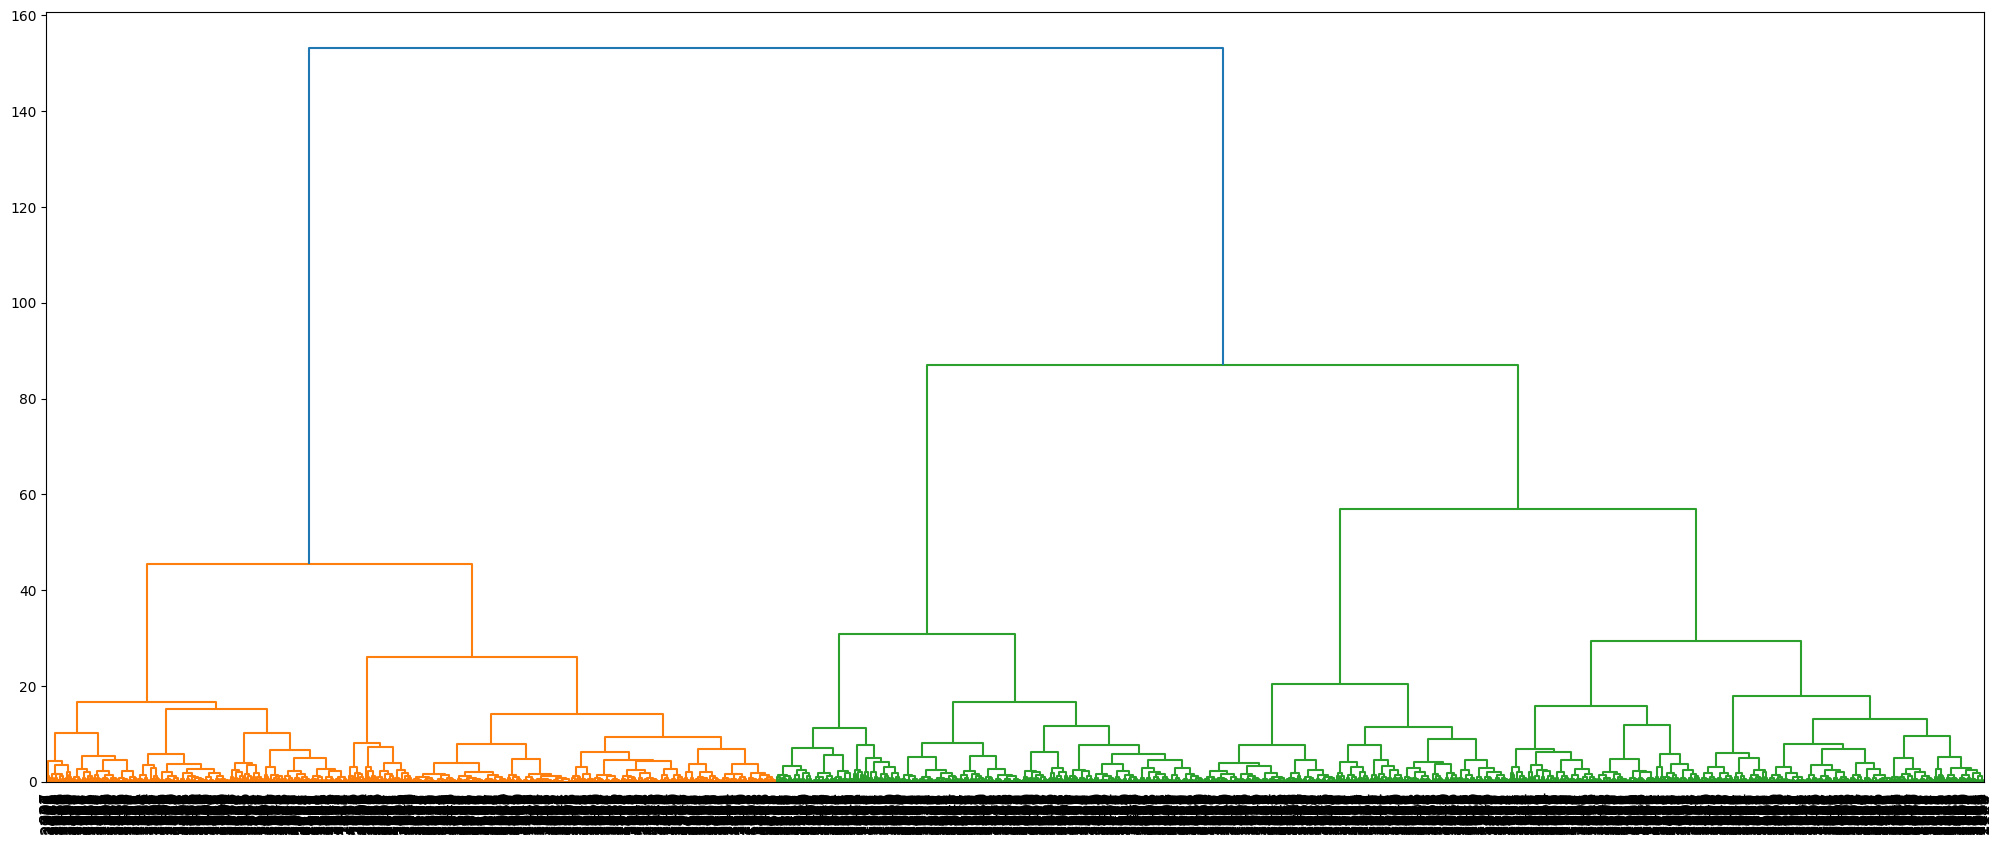

In [53]:
import matplotlib.pyplot as plt
plt.figure( figsize = (25, 10) )
dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
plt.show()

여러 T 값을 이용해 실루엣 스코어를 비교했고, 그 중 가장 적합했던 T 값을 현재 코드에 적용시켰다.

In [94]:
cut_tree = fcluster(clusters, t=40, criterion='distance')
cut_tree

array([1, 2, 3, ..., 4, 1, 1], dtype=int32)

In [95]:
pd.Series(cut_tree).value_counts()

1    1128
4     732
2     660
3     473
dtype: int64

## Step 3. Evaluation


In [99]:
from sklearn.metrics import silhouette_samples, silhouette_score
score_samples = silhouette_samples(data_prime, cut_tree)
print('Silhouette Score:', score_samples[:5], '\nSilhouette Score shape:', score_samples.shape, '\n')

average_score = silhouette_score(data_prime, cut_tree)
# np.mean(score_samples) == average_score: True
print('Silhouette Average Score:{0:.3f}'.format(average_score))

Silhouette Score: [ 0.52673657  0.53112607  0.47030671  0.03270806 -0.09653185] 
Silhouette Score shape: (2993,) 

Silhouette Average Score:0.377


In [100]:
data_prime['hc_cluster'] = cut_tree
data_prime['silhouette_coeff'] = score_samples
data_prime

,motivation,physical,emotional,hc_cluster,silhouette_coeff
0,-1.130394,-0.551188,-1.060694,1,0.526737
1,1.175179,1.238131,-0.175303,2,0.531126
2,-0.562395,-0.827510,1.277099,3,0.470307
3,-1.285799,1.433943,0.526536,1,0.032708
4,-0.421869,-1.022040,0.751456,4,-0.096532
...,...,...,...,...,...
2988,1.352899,-0.194302,1.903919,4,0.355818
2989,1.469130,0.565398,0.991440,4,0.342031
2990,1.428349,-1.735410,0.233037,4,0.426870
2991,-0.045136,-0.081705,-0.353101,1,0.348040


In [101]:
# 군집별 평균 silhouette_score 값
print(data_prime.groupby('hc_cluster')['silhouette_coeff'].mean())
print('표준편차:', data_prime.groupby('hc_cluster')['silhouette_coeff'].mean().std())

hc_cluster
1    0.357716
2    0.414116
3    0.446388
4    0.329139
Name: silhouette_coeff, dtype: float64
표준편차: 0.053127436088082604


In [102]:
cluster_g = data_prime.groupby('hc_cluster')

Motivation, Physical, Emotional 3개의 성분을 이용해 2차원 플롯 3개, 3차원 플롯 1개를 그렸다.

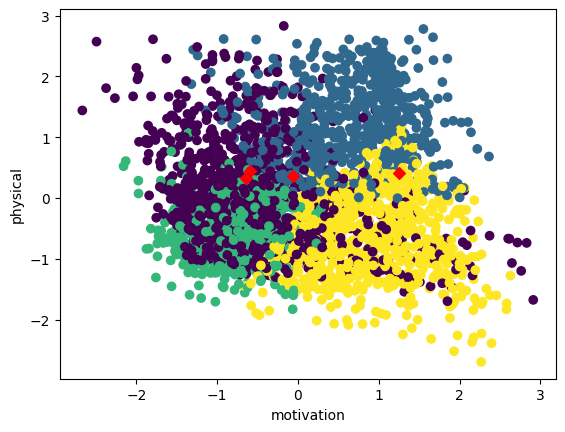

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(x=data_prime['motivation'], y=data_prime['physical'], c=data_prime['hc_cluster']) # 각 cluster 좌푯값 시각화

hc_centers = np.array(cluster_g.mean()) # 각 cluster별 centroid
plt.scatter(x=hc_centers[:,1], y=hc_centers[:,3], marker='D', c='r') # 각 cluster별 centroid 시각화
# marker='D', c='r' : 마커 모양은 Diamond, 색깔은 red
plt.xlabel('motivation')
plt.ylabel('physical')
plt.show()
# scatterplot = 군집들의 구분, centroid 확인 등등 

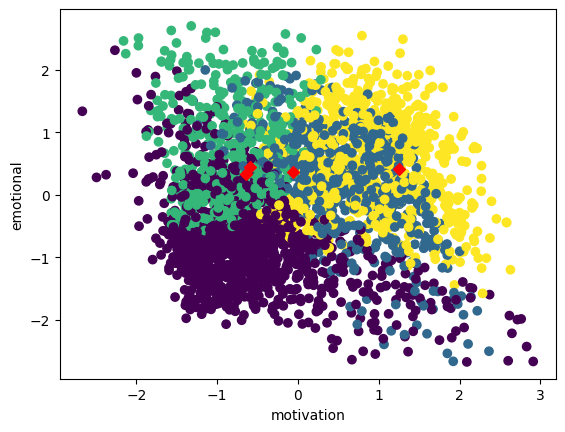

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(x=data_prime['motivation'], y=data_prime['emotional'], c=data_prime['hc_cluster']) # 각 cluster 좌푯값 시각화

hc_centers = np.array(cluster_g.mean()) # 각 cluster별 centroid
plt.scatter(x=hc_centers[:,1], y=hc_centers[:,3], marker='D', c='r') # 각 cluster별 centroid 시각화
# marker='D', c='r' : 마커 모양은 Diamond, 색깔은 red
plt.xlabel('motivation')
plt.ylabel('emotional')
plt.show()
# scatterplot = 군집들의 구분, centroid 확인 등등 

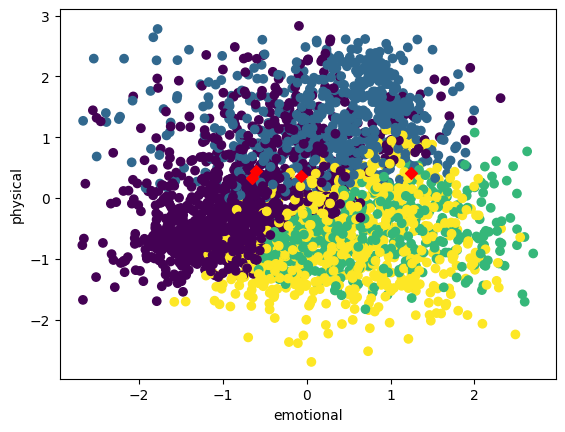

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(x=data_prime['emotional'], y=data_prime['physical'], c=data_prime['hc_cluster']) # 각 cluster 좌푯값 시각화

hc_centers = np.array(cluster_g.mean()) # 각 cluster별 centroid
plt.scatter(x=hc_centers[:,1], y=hc_centers[:,3], marker='D', c='r') # 각 cluster별 centroid 시각화
# marker='D', c='r' : 마커 모양은 Diamond, 색깔은 red
plt.xlabel('emotional')
plt.ylabel('physical')
plt.show()
# scatterplot = 군집들의 구분, centroid 확인 등등 

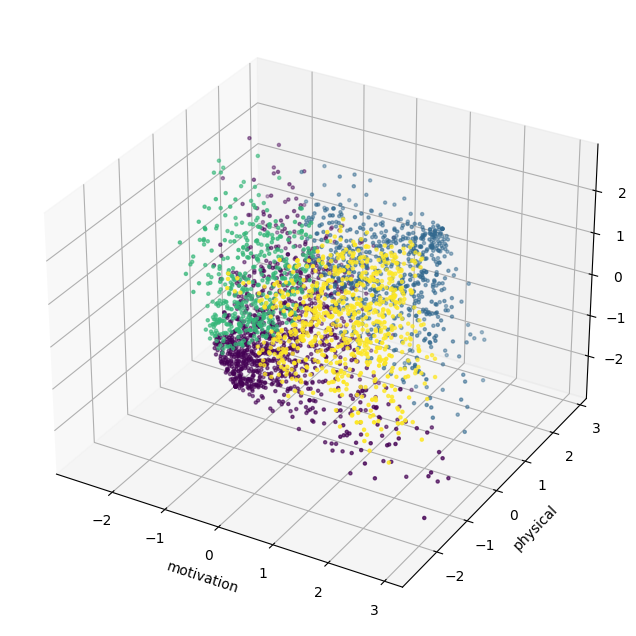

In [106]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_prime['motivation'], data_prime['physical'], data_prime['emotional'], s=5, c = data_prime['hc_cluster'])
ax.set_xlabel('motivation', rotation=150)
ax.set_ylabel('physical')
ax.set_zlabel(r'emotional', rotation=60)
plt.show()

## Step 4. EDA/Interpretation

In [107]:
# 군집별 통계(평균)
cluster_g.mean()

,motivation,physical,emotional,silhouette_coeff
hc_cluster,,,,
1,-0.603481,-0.060450,-0.790833,0.357716
2,0.624053,1.249414,0.279436,0.414116
3,-0.830384,-0.599195,0.707451,0.446388
4,0.903857,-0.646184,0.509573,0.329139


In [108]:
# 군집별 통계(표준편차)
cluster_g.std()

,motivation,physical,emotional,silhouette_coeff
hc_cluster,,,,
1,0.789836,0.819686,0.746070,0.179850
2,0.647023,0.634283,0.808546,0.150482
3,0.467665,0.472366,0.821267,0.093369
4,0.660407,0.697332,0.769373,0.138457


-Cluster 1: 동기부여가 매우 낮고, 신체적 문제가 적으며 감정 기복이 심하지 않은 사람

-Cluster 2: 동기부여가 낮고 신체적 문제가 적으며 감정 기복이 매우 심하지 않은 사람

-Cluster 3: 동기부여가 낮지 않으며 신체적 문제가 많으고 감정 기복이 매우 심하지 않은 사람

-Cluster 4: 동기부여가 매우 낮고 신체적 문제가 매우 적으며 감정 기복이 아주 심한 사람

-Cluster 5: 동기부여가 매우 높고 신체적 문제가 없으며 감정 기복이 어느정도 있는 사람


# k-평균 클러스터링 (K-means Clustering)



In [109]:
data_prime = scaled.copy()

## Step 1. K 선정


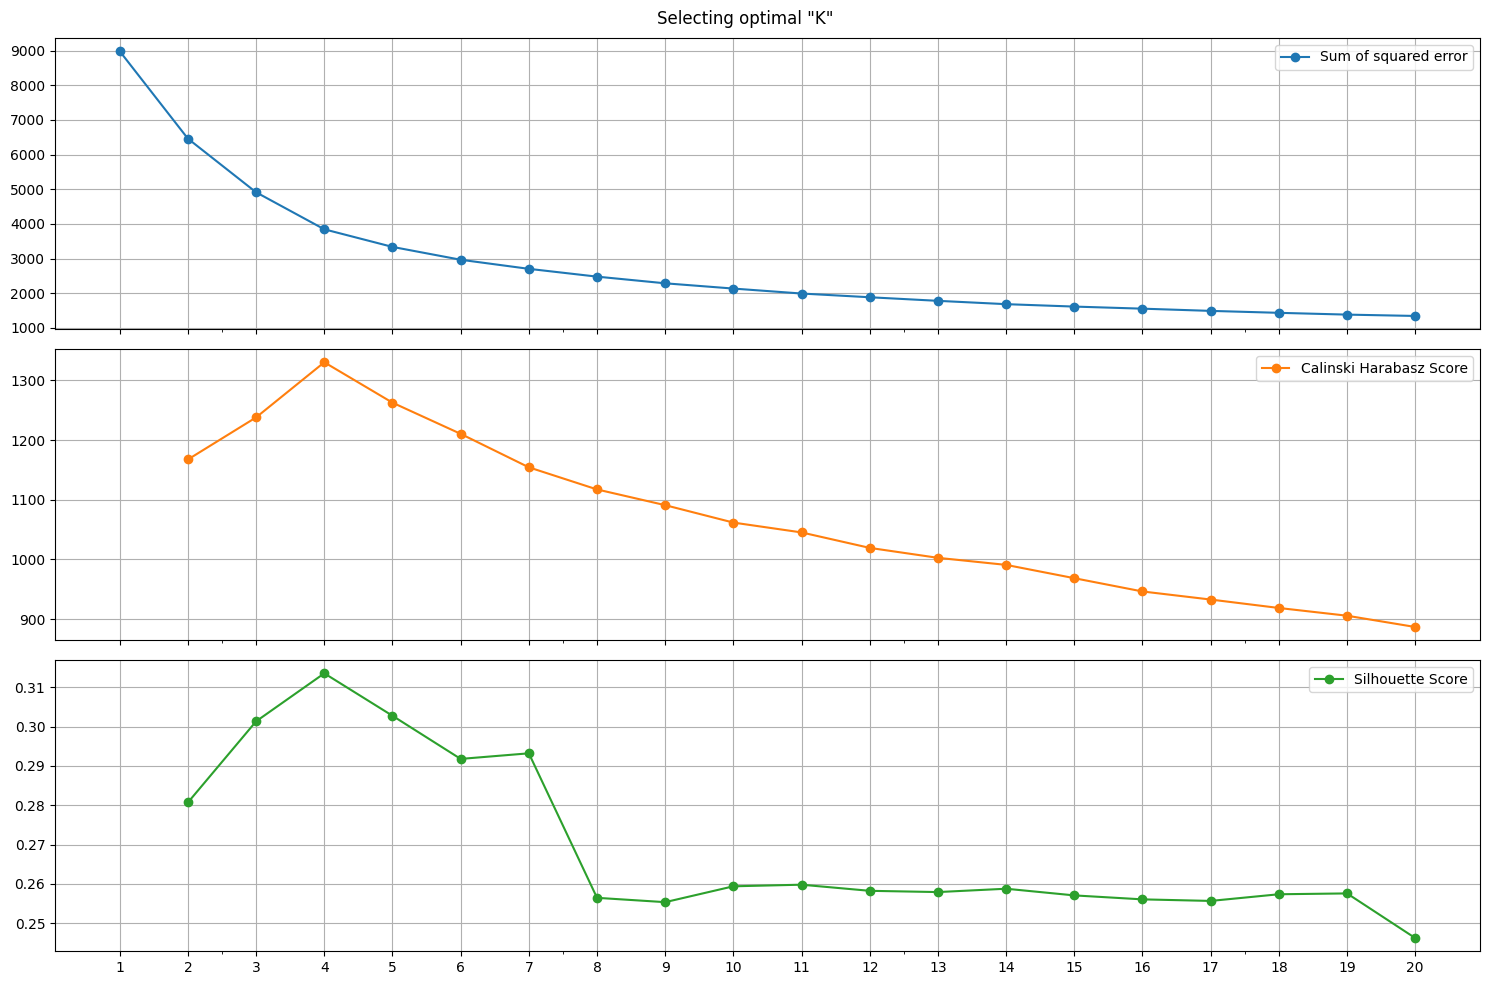

In [110]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

search_range = range(1, 21)
report = {}
for k in search_range:
    temp_dict = {}
    kmeans = KMeans(init='k-means++',
                    algorithm='auto',
                    n_clusters=k,
                    max_iter=1000,
                    random_state=1,
                    verbose=0).fit(data_prime)
    inertia = kmeans.inertia_
    temp_dict['Sum of squared error'] = inertia
    try:
        cluster = kmeans.predict(data_prime)
        chs = calinski_harabasz_score(data_prime, cluster)
        ss = silhouette_score(data_prime, cluster)
        temp_dict['Calinski Harabasz Score'] = chs
        temp_dict['Silhouette Score'] = ss
        report[k] = temp_dict
    except:
        report[k] = temp_dict

report_df = pd.DataFrame(report).T
report_df.plot(figsize=(15, 10),
               xticks=search_range,
               grid=True,
               title=f'Selecting optimal "K"',
               subplots=True,
               marker='o',
               sharex=True)
plt.tight_layout()

Elbow method, Silhouette score, Calinski Harabasz score를 모두 활용했을 때 K=4 라는 동일한 결과가 나오기 때문에 K=4로 설정하하여 클러스터링을 진행했다.

## Step 2. K-means clustering

In [111]:
from sklearn.cluster import KMeans
'''
init: {'k-means++', 'random'}, default='k-means++'
algorithm: {'auto', 'full', 'elkan'}, default='auto'
'''
# elkan = cluster가 잘 구분된 데이터에는 활용하기 좋지만, 데이터가 많을수록 메모리 소요량이 큼
# 초기값 선정에 따라 결과값이 바뀔 수 있어서 random state 지정 

model = KMeans(n_clusters=4, random_state=312, algorithm='auto')
model.fit(data_prime)

KMeans(algorithm='auto', n_clusters=4, random_state=312)

In [112]:
# 각 군집(cluster) 표시
pred = model.predict(data_prime)
pred

array([1, 0, 2, ..., 3, 1, 1], dtype=int32)

In [113]:
# 군집별 centroids의 좌표값
centroids = model.cluster_centers_
centroids = pd.DataFrame(centroids, columns = data_prime.columns)

In [114]:
centroids

,motivation,physical,emotional
0,0.396454,1.346348,0.242703
1,-0.789847,-0.415461,-0.799223
2,-0.336117,-0.332243,1.126591
3,1.245174,-0.668901,-0.222656


In [115]:
# Observation and cluster
data_prime['cluster'] = pred
data_prime

,motivation,physical,emotional,cluster
0,-1.130394,-0.551188,-1.060694,1
1,1.175179,1.238131,-0.175303,0
2,-0.562395,-0.827510,1.277099,2
3,-1.285799,1.433943,0.526536,0
4,-0.421869,-1.022040,0.751456,2
...,...,...,...,...
2988,1.352899,-0.194302,1.903919,2
2989,1.469130,0.565398,0.991440,0
2990,1.428349,-1.735410,0.233037,3
2991,-0.045136,-0.081705,-0.353101,1


## Step 3. Evaluation

In [116]:
from sklearn.metrics import silhouette_samples, silhouette_score
data_prime['k_means_cluster'] = pred
data_prime['k_silhouette_coeff'] = silhouette_samples(data_prime, data_prime['k_means_cluster'])

k_average_score = silhouette_score(data_prime, data_prime['k_means_cluster'])
print('Average Silhouette Score:{0:.3f}'.format(k_average_score))

Average Silhouette Score:0.477


In [117]:
# 군집별 평균 silhouette_score 값
print(data_prime.groupby('k_means_cluster')['k_silhouette_coeff'].mean())

# silhouette_score 표준편차
print('표준편차:', data_prime.groupby('k_means_cluster')['k_silhouette_coeff'].mean().std())

k_means_cluster
0    0.476731
1    0.551366
2    0.407482
3    0.433578
Name: k_silhouette_coeff, dtype: float64
표준편차: 0.06290605551590168


K-mean 클러스트링의 결과로
Motivation, Physical, Emotional 3개의 성분을 이용해 2차원 플롯 3개, 3차원 플롯 1개를 그렸다.

Text(0, 0.5, 'physical')

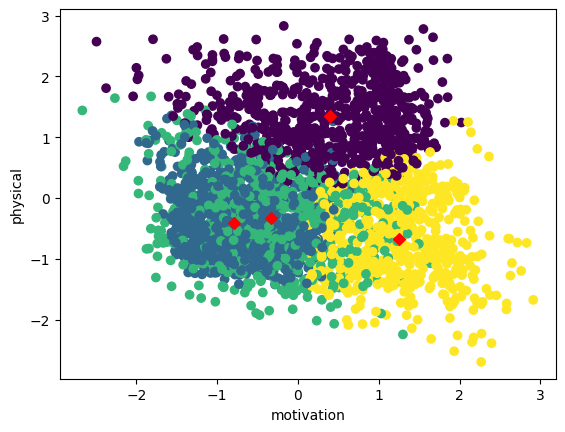

In [118]:
# 군집결과 시각화
plt.scatter(x=data_prime['motivation'], y=data_prime['physical'], c=data_prime['k_means_cluster'])
plt.scatter(x=centroids.loc[:,"motivation"], y=centroids.loc[:,"physical"], marker='D', c='r') # x, y는 각각 factor 1번째(Neuroticism)와 4번째(Agreeableness)
plt.xlabel('motivation')
plt.ylabel('physical')

Text(0, 0.5, 'emotional')

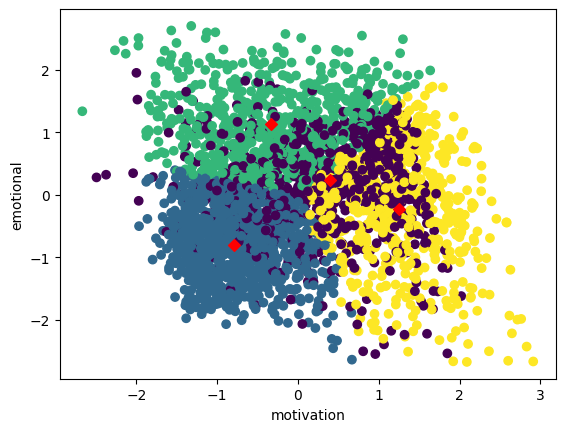

In [119]:
# 군집결과 시각화
plt.scatter(x=data_prime['motivation'], y=data_prime['emotional'], c=data_prime['k_means_cluster'])
plt.scatter(x=centroids.loc[:,"motivation"], y=centroids.loc[:,"emotional"], marker='D', c='r') # x, y는 각각 factor 1번째(Neuroticism)와 4번째(Agreeableness)
plt.xlabel('motivation')
plt.ylabel('emotional')

Text(0, 0.5, 'physical')

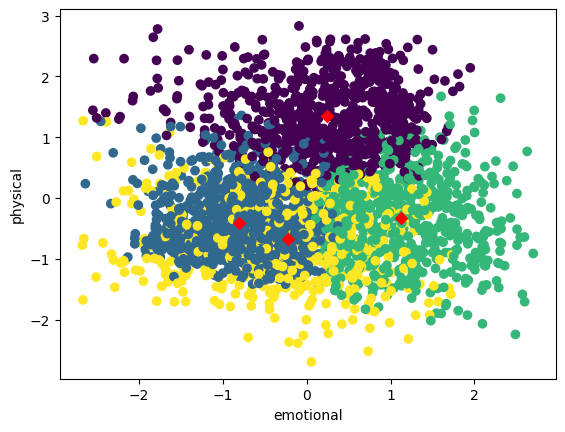

In [120]:
# 군집결과 시각화
plt.scatter(x=data_prime['emotional'], y=data_prime['physical'], c=data_prime['k_means_cluster'])
plt.scatter(x=centroids.loc[:,"emotional"], y=centroids.loc[:,"physical"], marker='D', c='r') # x, y는 각각 factor 1번째(Neuroticism)와 4번째(Agreeableness)
plt.xlabel('emotional')
plt.ylabel('physical')

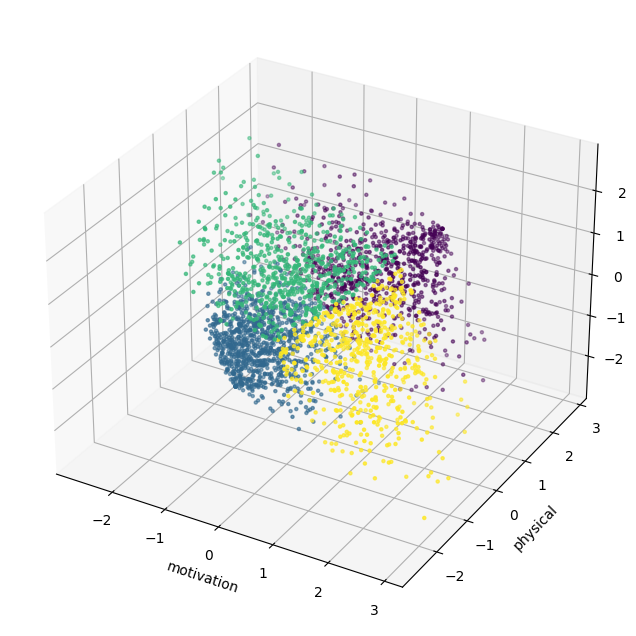

In [121]:
# 군집결과 시각화
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_prime['motivation'], data_prime['physical'], data_prime['emotional'], s=5, c=data_prime['k_means_cluster'])
ax.set_xlabel('motivation', rotation=150)
ax.set_ylabel('physical')
ax.set_zlabel(r'emotional', rotation=60)

plt.show()

## Step 4. EDA/Interpretation

In [122]:
# 군집별 통계(평균)
data_prime.groupby('k_means_cluster').mean()

,motivation,physical,emotional,cluster,k_silhouette_coeff
k_means_cluster,,,,,
0,0.396454,1.346348,0.242703,0.0,0.476731
1,-0.789847,-0.415461,-0.799223,1.0,0.551366
2,-0.331846,-0.334403,1.127200,2.0,0.407482
3,1.245753,-0.667572,-0.228088,3.0,0.433578


-Cluster0: 신체적으로 특징이 나타나는 사람

-Cluster1: 동기부여도 없으며 감정조절에 문제가 있는 사람

-Cluster2: 감정조절에 문제가 있는 사람

-Cluster3: 동기부여가 안되는 사람



In [123]:
# 군집별 통계(표준편차)
data_prime.groupby('k_means_cluster').std() 

,motivation,physical,emotional,cluster,k_silhouette_coeff
k_means_cluster,,,,,
0,0.783606,0.574978,0.747034,0.0,0.121312
1,0.499609,0.542890,0.560313,0.0,0.103424
2,0.762465,0.682186,0.595307,0.0,0.095349
3,0.578624,0.683416,0.903705,0.0,0.096354


In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns

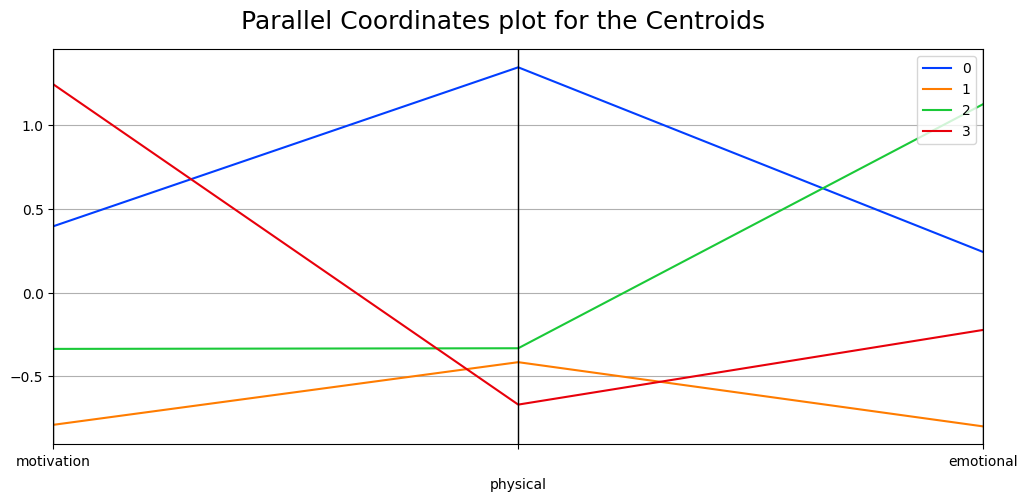

In [125]:
palette = sns.color_palette("bright", 10)
# Create a data frame containing our centroids
'''https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/3a.%20K-Means%20Clustering.ipynb'''
centroids['cluster'] = centroids.index

def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

display_parallel_coordinates_centroids(centroids, 5)